In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.image as img
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import tensorflow as tf

In [2]:
# Assigning paths to variables
INPUT_PATH = os.path.join('e:/datasets')
DATASET_DIR = os.path.join(INPUT_PATH, 'landmark-recognition-2020')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_LABELMAP_PATH = os.path.join(DATASET_DIR, 'train.csv')

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'e:/datasets/working/training'
validation_dir = 'e:/datasets/working/validation'
test_dir = 'e:/datasets/working/testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size = 16,
    class_mode='categorical',
    seed=42)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size = 16,
    class_mode='categorical',
    seed=42)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size = 1,
    class_mode='categorical',
    seed=42)

Found 48000 images belonging to 400 classes.
Found 16000 images belonging to 400 classes.
Found 16000 images belonging to 400 classes.


In [4]:
MobileNetV2summary = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
)

MobileNetV2summary.trainable = True

MobileNetV2summary.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [5]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
with strategy.scope():
    MobileNetV2Model = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
    )

    MobileNetV2Model.trainable = True
    model = Sequential()
    model.add(MobileNetV2Model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(400, activation='softmax'))
    model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Training

In [7]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/50
3000/3000 [==============================] - 1536s 506ms/step - loss: 5.0744 - accuracy: 0.1068 - precision: 0.9227 - recall: 0.0037 - val_loss: 3.6815 - val_accuracy: 0.2756 - val_precision: 0.8864 - val_recall: 0.0414
Epoch 2/50
3000/3000 [==============================] - 601s 200ms/step - loss: 3.2314 - accuracy: 0.3531 - precision: 0.9463 - recall: 0.0808 - val_loss: 2.3722 - val_accuracy: 0.4764 - val_precision: 0.8899 - val_recall: 0.2394
Epoch 3/50
3000/3000 [==============================] - 595s 198ms/step - loss: 2.4313 - accuracy: 0.4824 - precision: 0.9351 - recall: 0.2070 - val_loss: 1.9260 - val_accuracy: 0.5643 - val_precision: 0.8829 - val_recall: 0.3637
Epoch 4/50
3000/3000 [==============================] - 600s 200ms/step - loss: 2.0157 - accuracy: 0.5552 - precision: 0.9252 - recall: 0.3106 - val_loss: 1.6449 - val_accuracy: 0.6159 - val_precision: 0.8703 - val_recall: 0.4671
Epoch 5/50
3000/3000 [==============================] - 604s 201ms/step - loss:

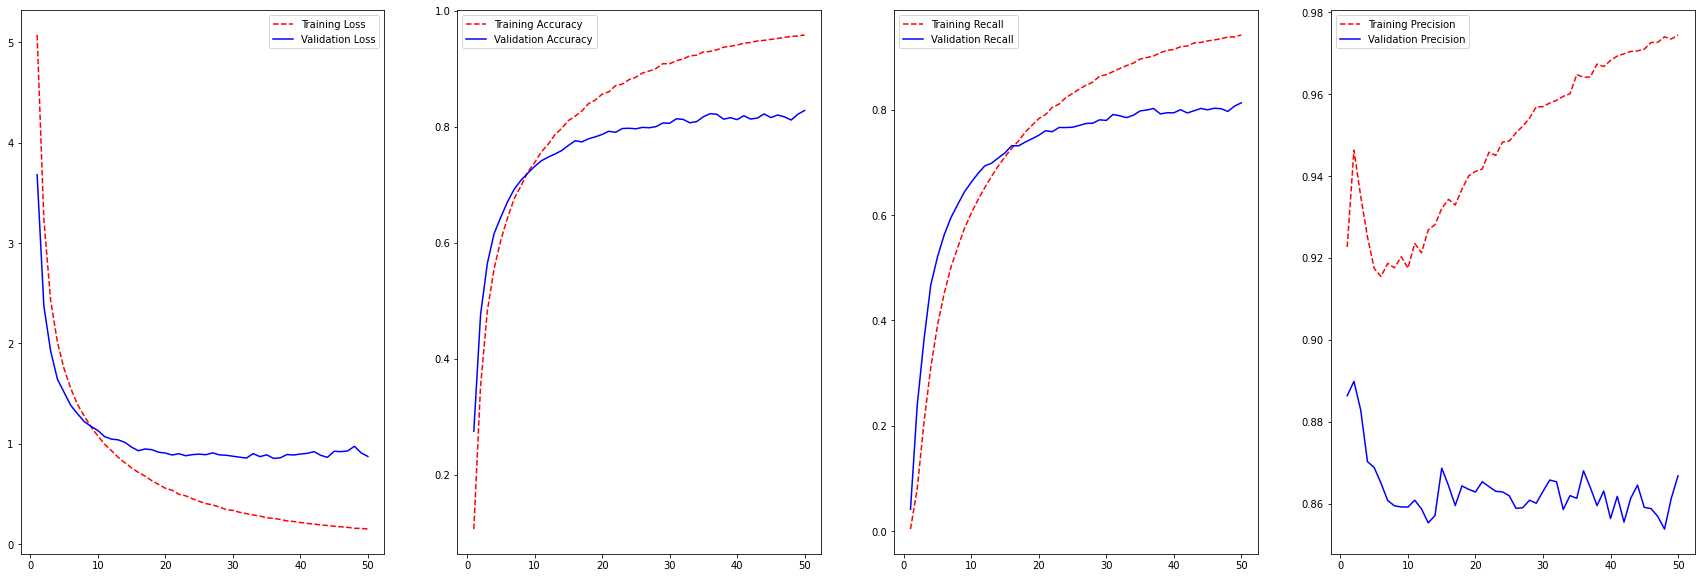

In [8]:


# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

#let's add accuracy
training_recall = history.history['recall']
validation_recall = history.history['val_recall']

#let's add accuracy
training_precision = history.history['precision']
validation_precision = history.history['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [9]:
scores = model.evaluate(test_generator)
print('loss:', scores[0])
print('accuracy:', scores[1])
print('precision:', scores[2])
print('recall:', scores[3])

16000/16000 [==============================] - 307s 19ms/step - loss: 0.8515 - accuracy: 0.8277 - precision: 0.8654 - recall: 0.8123
loss: 0.8514732122421265
accuracy: 0.8276875019073486
precision: 0.865370512008667
recall: 0.8123124837875366


Save model


In [10]:

model.save('mobile_net_v2_25epochs.h5')

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [12]:
MobileNetV2summary = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
)

MobileNetV2summary.trainable = True

MobileNetV2summary.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [13]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
with strategy.scope():
    MobileNetV2Model = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(224, 224, 3)
    )

    MobileNetV2Model.trainable = True
    model2 = Sequential()
    model2.add(MobileNetV2Model)
    model2.add(GlobalAveragePooling2D())
    model2.add(Dense(400, activation='softmax'))
    model2.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               512400    
Total params: 2,770,384
Trainable params: 2,736,272
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
history2 = model2.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/5
3000/3000 [==============================] - 807s 265ms/step - loss: 5.0689 - accuracy: 0.1071 - precision_1: 0.9552 - recall_1: 0.0040 - val_loss: 3.6033 - val_accuracy: 0.2855 - val_precision_1: 0.9456 - val_recall_1: 0.0434
Epoch 2/5
3000/3000 [==============================] - 771s 257ms/step - loss: 3.2103 - accuracy: 0.3574 - precision_1: 0.9429 - recall_1: 0.0804 - val_loss: 2.3814 - val_accuracy: 0.4769 - val_precision_1: 0.8895 - val_recall_1: 0.2329
Epoch 3/5
3000/3000 [==============================] - 761s 254ms/step - loss: 2.4119 - accuracy: 0.4858 - precision_1: 0.9333 - recall_1: 0.2104 - val_loss: 1.8824 - val_accuracy: 0.5688 - val_precision_1: 0.8757 - val_recall_1: 0.3894
Epoch 4/5
3000/3000 [==============================] - 1203s 401ms/step - loss: 2.0043 - accuracy: 0.5573 - precision_1: 0.9264 - recall_1: 0.3140 - val_loss: 1.6662 - val_accuracy: 0.6099 - val_precision_1: 0.8662 - val_recall_1: 0.4674
Epoch 5/5
3000/3000 [==============================

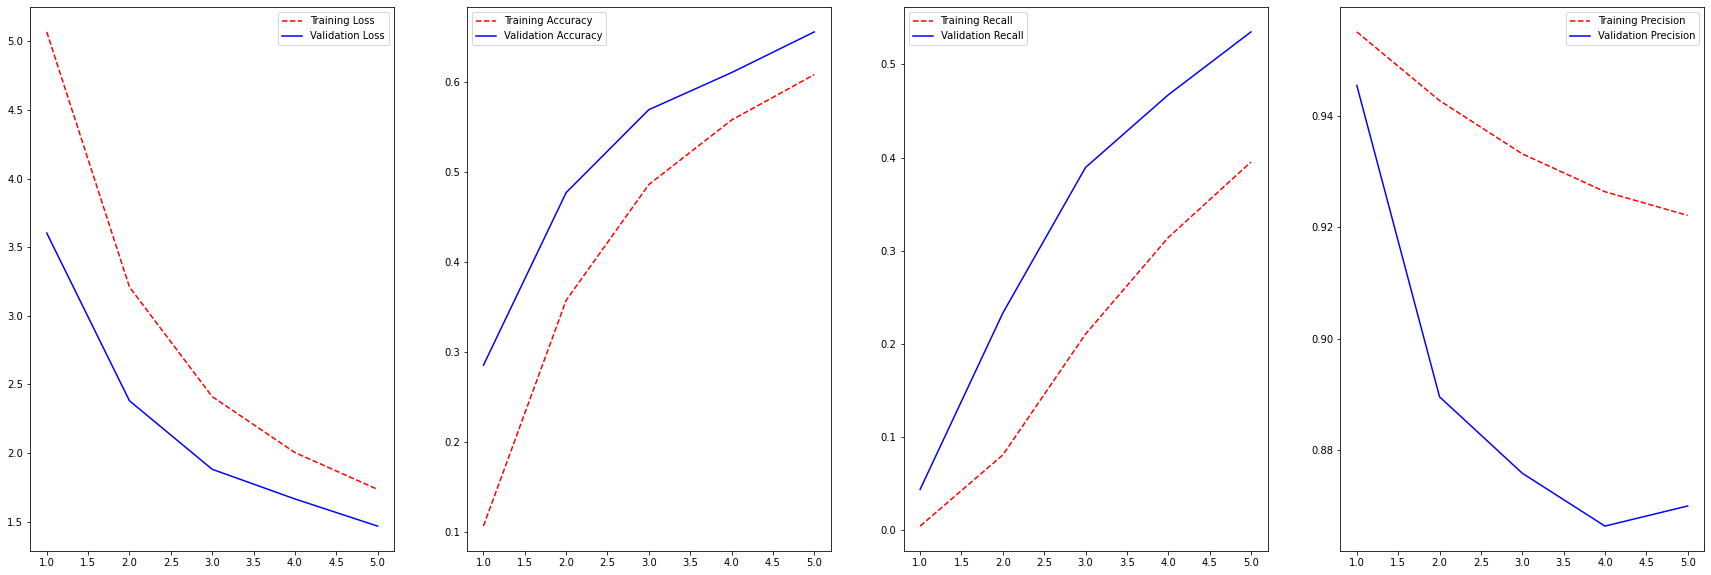

In [17]:
# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

#let's add accuracy
training_recall = history2.history['recall_1']
validation_recall = history2.history['val_recall_1']

#let's add accuracy
training_precision = history2.history['precision_1']
validation_precision = history2.history['val_precision_1']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()

In [18]:
scores2 = model2.evaluate(test_generator)
print('loss:', scores2[0])
print('accuracy:', scores2[1])
print('precision:', scores2[2])
print('recall:', scores2[3])

16000/16000 [==============================] - 285s 18ms/step - loss: 1.4398 - accuracy: 0.6612 - precision_1: 0.8711 - recall_1: 0.5371
loss: 1.4398274421691895
accuracy: 0.6612499952316284
precision: 0.8710723519325256
recall: 0.5371249914169312


In [19]:
model2.save('mobile_net_v2_5epochs.h5')
with open('/trainHisеV2sDict', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

In [20]:
np.save('history_mobilenet_v3.npy',history.history)
np.save('history_mobilenet_v2.npy',history2.history)

In [21]:
hist = np.load('history_mobilenet_v3.npy',allow_pickle='TRUE').item()

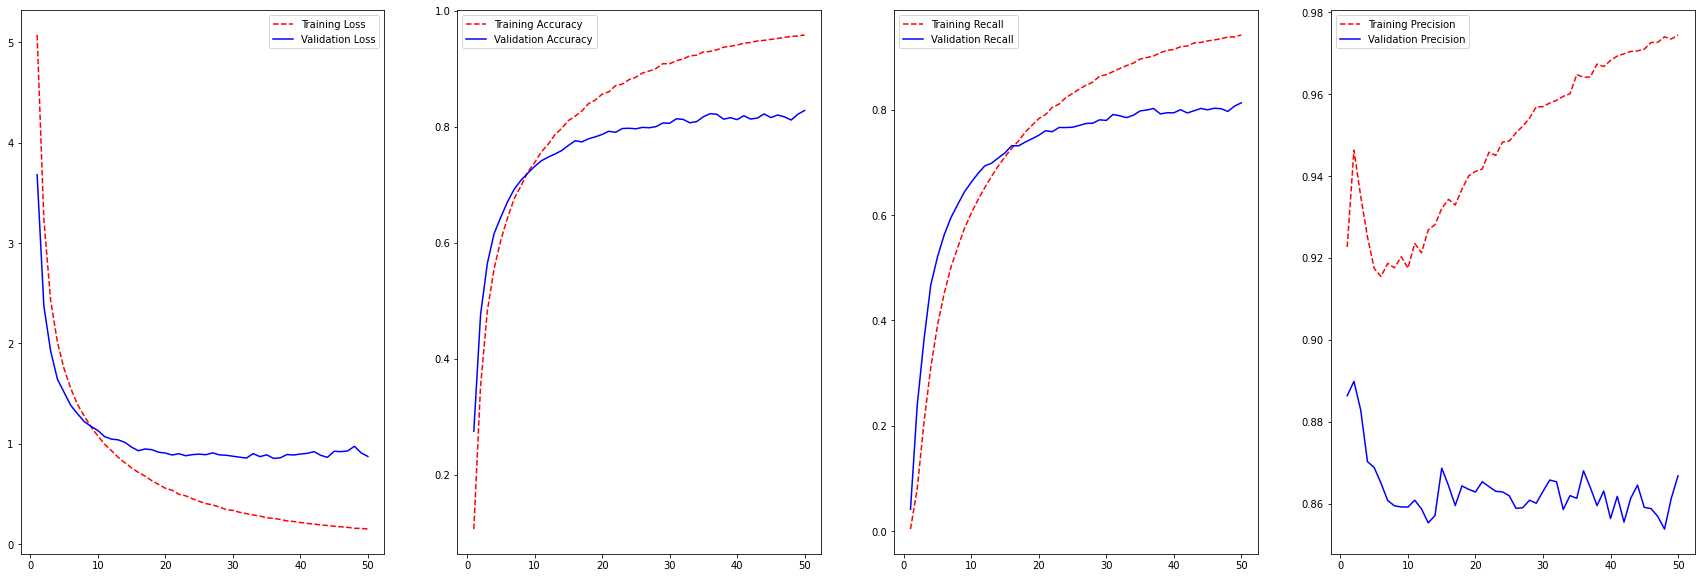

In [24]:
# Visualize loss
fig, axs = plt.subplots(1, 4, figsize = (30, 10)) # create plt it's better to use subplots with 2-4 plots of loss, accuracy, recall or other metrics
                                                
training_loss = hist['loss']
validation_loss = hist['val_loss']
#stopped_epoch = model_checkpoint.stopped_epoch   # redundant 
#epochs = range(stopped_epoch+1) ''' 
epochs = range(1, len(training_loss) + 1) # better way to calculate number of epochs

#let's add accuracy
training_accuracy = hist['accuracy']
validation_accuracy = hist['val_accuracy']

#let's add accuracy
training_recall = hist['recall']
validation_recall = hist['val_recall']

#let's add accuracy
training_precision = hist['precision']
validation_precision = hist['val_precision']

axs[0].plot(epochs, training_loss, 'r--')
axs[0].plot(epochs, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epochs, training_accuracy, 'r--')
axs[1].plot(epochs, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

axs[2].plot(epochs, training_recall, 'r--')
axs[2].plot(epochs, validation_recall, 'b-')
axs[2].legend(['Training Recall', 'Validation Recall'])

axs[3].plot(epochs, training_precision, 'r--')
axs[3].plot(epochs, validation_precision, 'b-')
axs[3].legend(['Training Precision', 'Validation Precision'])

plt.show()